In [1]:
from sem_objnav.segment.infer import EmsanetWrapper


model = EmsanetWrapper(ckpt_path='/home/sai/Desktop/multi-object-search/third_party/EMSANet/trained_models/sunrgbd/r34_NBt1D_pre.pth', config_path='/home/sai/Desktop/multi-object-search/third_party/EMSANet/trained_models/sunrgbd/argsv.txt', map_schema="objnav_occ_id")

/home/sai/miniconda3/envs/hobjn/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
pybullet build time: May  2 2023 05:58:25


[Warning] Forced `rgb-encoder-backbone-resnet-block`, to be 'nonbottleneck1d' as `rgb-encoder-backbone-block` was given.
[Warning] Forced `depth-encoder-backbone-resnet-block`, to be 'nonbottleneck1d' as `depth-encoder-backbone-block` was given.
[Warning] `validation-batch-size` not given, using default: 24.
[Warning] Dataset 'sunrgbd' does not have a 'valid' split, using 'test' split instead.
Running with args:
 {
    "action": null,
    "activation": "relu",
    "aug_scale_max": 1.4,
    "aug_scale_min": 1.0,
    "batch_size": 8,
    "cache_dataset": false,
    "checkpointing_best_only": false,
    "checkpointing_metrics": null,
    "checkpointing_skip": 0.0,
    "context_module": "ppm",
    "dataset": "sunrgbd",
    "dataset_path": null,
    "debug": false,
    "decoder_normalization": "batchnorm",
    "depth_encoder_backbone": "resnet34",
    "depth_encoder_backbone_block": "nonbottleneck1d",
    "depth_encoder_backbone_pretrained_weights_filepath": null,
    "depth_encoder_backbon

In [2]:
import glob
import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


In [3]:
# from nicr_mt_scene_analysis.metric.miou import MeanIntersectionOverUnion
# # common

# {'chair': 3, 'bed': 4, 'plant': 5, 'toilet': 6, 'tv_monitor': 7, 'sofa': 8}

# common2pred = {1: [30, 75, 19], 2: [7], 4: [65], 5: [43, 130, 141, 89], 6: [23], 3: [17]}

# goals = ["chair", "bed", "plant", "toilet", "tv_monitor", "sofa"]
# predconformal_scores = {k: [] for k in common2pred}


In [4]:
def calculate_bin_stats(sem_gt, sem_pred, confidence, NUM_BINS):
    bin_accuracies, bin_confidences, bin_counts = (
        np.zeros(NUM_BINS),
        np.zeros(NUM_BINS),
        np.zeros(NUM_BINS),
    )
    valid_mask = (sem_pred > 2)
    for j in range(NUM_BINS):
        p1, p2 = j / NUM_BINS, (j + 1) / NUM_BINS
        confidence_bin_mask = (confidence > p1) & (confidence <= p2) & valid_mask

        bin_count = confidence_bin_mask.sum()
        if bin_count > 0:
            points_, labels_ = (
                sem_pred[confidence_bin_mask],
                sem_gt[confidence_bin_mask],
            )
            bin_accuracy = (points_ == labels_).sum()
            bin_confidence = confidence[confidence_bin_mask].sum()

            bin_accuracies[j] = bin_accuracy
            bin_confidences[j] = bin_confidence
            bin_counts[j] = bin_count
    return bin_accuracies, bin_confidences, bin_counts

In [7]:
import random
import torch

def compute(temp=1.0, split="train", num_items=None):
    image_dir = (
    f"/home/sai/Desktop/multi-object-search/third_party/EMSANet/datasets/hm3d_objnav_8_classes/{split}/rgb"
    )
    depth_dir = f"/home/sai/Desktop/multi-object-search/third_party/EMSANet/datasets/hm3d_objnav_8_classes/{split}/depth"
    semantic_seg_gt = f"/home/sai/Desktop/multi-object-search/third_party/EMSANet/datasets/hm3d_objnav_8_classes/{split}/semantic_8"
    rgb_images = sorted(glob.glob(image_dir + "/*.png"))
    depth_images = sorted(glob.glob(depth_dir + "/*.png"))
    seg_gt_images = sorted(glob.glob(semantic_seg_gt + "/*.png"))
    if num_items is not None:
        rgb_images = random.Random(42).sample(rgb_images, num_items)
        seg_gt_images = random.Random(42).sample(seg_gt_images, num_items)
        depth_images = random.Random(42).sample(depth_images, num_items)
        
    #miou = MeanIntersectionOverUnion(n_classes=7, ignore_first_class=True)

    NUM_BINS = 10
    bin_accuracies, bin_confidences, bin_counts = (
        np.zeros(NUM_BINS),
        np.zeros(NUM_BINS),
        np.zeros(NUM_BINS),
    )
    ubin_accuracies, ubin_confidences, ubin_counts = (
        np.zeros(NUM_BINS),
        np.zeros(NUM_BINS),
        np.zeros(NUM_BINS),
    )
    model.temp = temp
    for i in tqdm.tqdm(
        range(len(rgb_images))
    ):
        image = rgb_images[i]
        depth = depth_images[i]
        semantic_gt = seg_gt_images[i]
        # Get the semantic segmentation ground truth for the image
        semantic_gt_img = Image.open(semantic_gt)
        semantic_gt = torch.from_numpy(np.array(semantic_gt_img))
        semantic_gt -= 2
        semantic_gt[semantic_gt > 200] = 0
        image = np.array(Image.open(image))
        depth_image = np.array(Image.open(depth))
        out = model.predict(image, depth_image)
        normalized_entropy = out["semantic_unc"]
        conf = (1 - normalized_entropy)
        segmentation_pred = out["semantic"] - 2
        segmentation_max_prob = out["semantic_max_prob"]
  
        b_acc, b_conf, b_cnt = calculate_bin_stats(semantic_gt.cpu().numpy(), segmentation_pred, segmentation_max_prob, NUM_BINS)
        ub_acc, ub_conf, ub_cnt = calculate_bin_stats(semantic_gt.cpu().numpy(), segmentation_pred, conf, NUM_BINS)
        bin_accuracies += np.array(b_acc)
        bin_confidences += np.array(b_conf)
        bin_counts += np.array(b_cnt)
        
        ubin_accuracies += np.array(ub_acc)
        ubin_confidences += np.array(ub_conf)
        ubin_counts += np.array(ub_cnt)
    bin_confidences_avg = np.divide(
            bin_confidences,
            bin_counts,
            out=np.zeros_like(bin_confidences),
            where=bin_counts != 0,
    )
    bin_accuracies_avg = np.divide(
        bin_accuracies,
        bin_counts,
        out=np.zeros_like(bin_accuracies),
        where=bin_counts != 0,
    )
    overall_ece = (
        np.sum(
            bin_counts * np.abs(bin_accuracies_avg - bin_confidences_avg),
        )
        / bin_counts.sum()
    )
    ubin_confidences_avg = np.divide(
            ubin_confidences,
            ubin_counts,
            out=np.zeros_like(ubin_confidences),
            where=ubin_counts != 0,
    )
    ubin_accuracies_avg = np.divide(
        ubin_accuracies,
        ubin_counts,
        out=np.zeros_like(ubin_accuracies),
        where=ubin_counts != 0,
    )
    overal_uece = (
        np.sum(
            ubin_counts * np.abs(ubin_accuracies_avg - ubin_confidences_avg),
        )
        / ubin_counts.sum()
    )
    
    return bin_confidences_avg, bin_accuracies_avg, overall_ece, ubin_confidences_avg, ubin_accuracies_avg, overal_uece

def plot(bin_confidences, bin_accuracies, title, save_path=None):
    plt.title(title)
    plt.plot([0, 1], [0, 1], color="black", linewidth=2)
    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")
    plt.plot(bin_confidences, bin_accuracies, color="b")
    plt.legend(["Perfect calibration", "Model"])
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

100%|██████████| 100/100 [00:21<00:00,  4.68it/s]


overall ece 0.21343397123812036
overall uece 0.20039540596383112


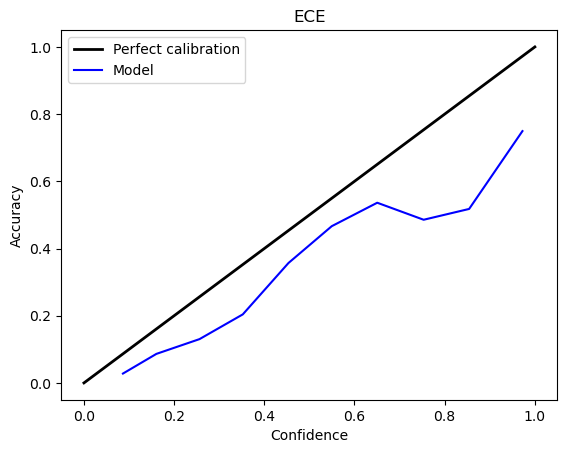

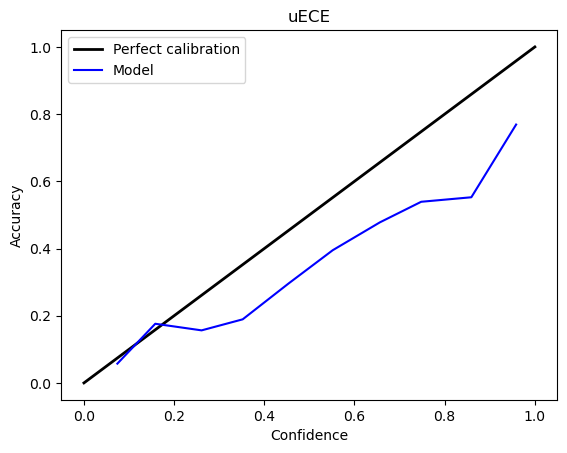

In [22]:
bin_confidences_avg, bin_accuracies_avg, overall_ece, ubin_confidences_avg, ubin_accuracies_avg, overal_uece  = compute(temp=2.1, split="train", num_items=100)
print("overall ece", overall_ece)
print("overall uece", overal_uece)
plot(bin_confidences_avg, bin_accuracies_avg, "ECE")
plot(ubin_confidences_avg, ubin_accuracies_avg, "uECE")


In [ ]:
plot(bin_confidences_avg, bin_accuracies_avg, "After calibration (T=2.5)")

100%|██████████| 2000/2000 [08:16<00:00,  4.03it/s]


overall ece 0.3572534476871969
overall uece 0.3742498296661333


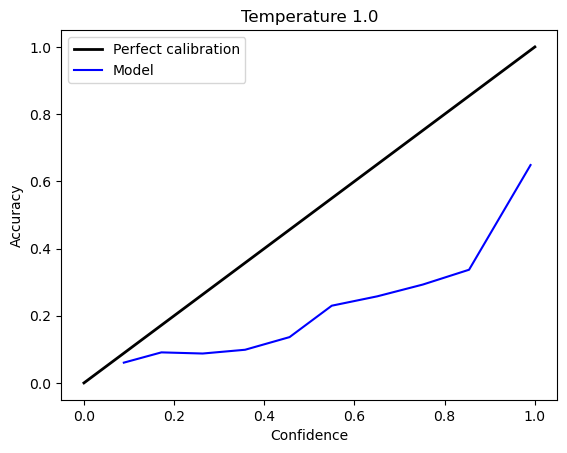

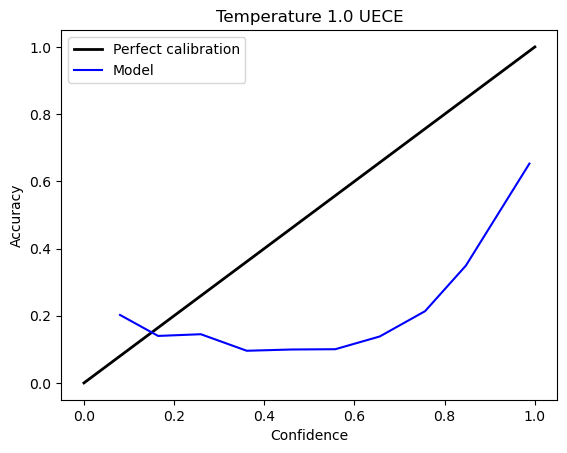

100%|██████████| 2000/2000 [07:28<00:00,  4.46it/s]

overall ece 0.3303857164330146
overall uece 0.3456116551164196


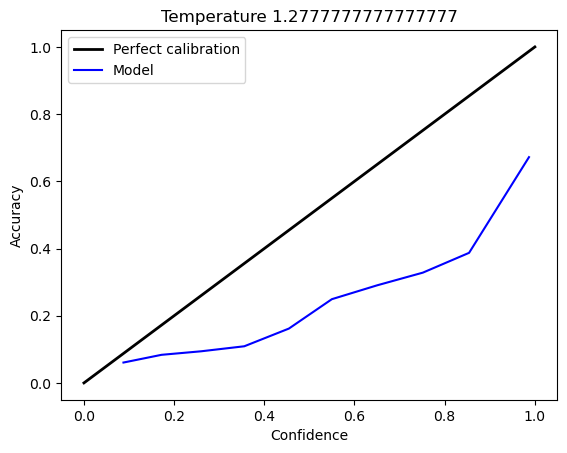

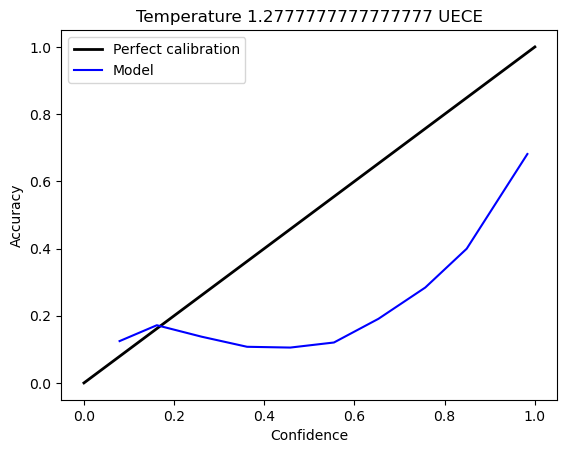

100%|██████████| 2000/2000 [06:27<00:00,  5.16it/s]


overall ece 0.2997051886571227
overall uece 0.30950215619672183


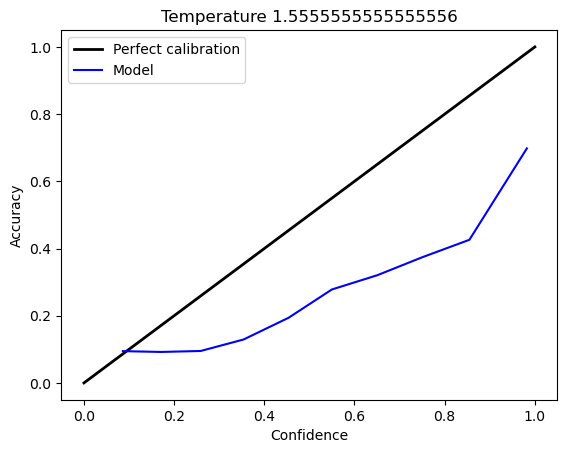

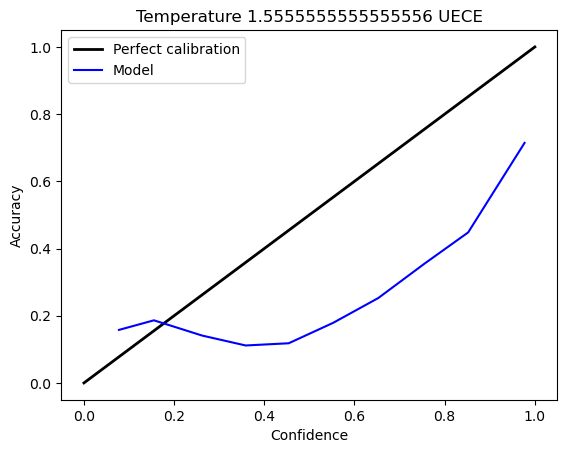

100%|██████████| 2000/2000 [05:07<00:00,  6.50it/s]


overall ece 0.2644687240076948
overall uece 0.26491749834511596


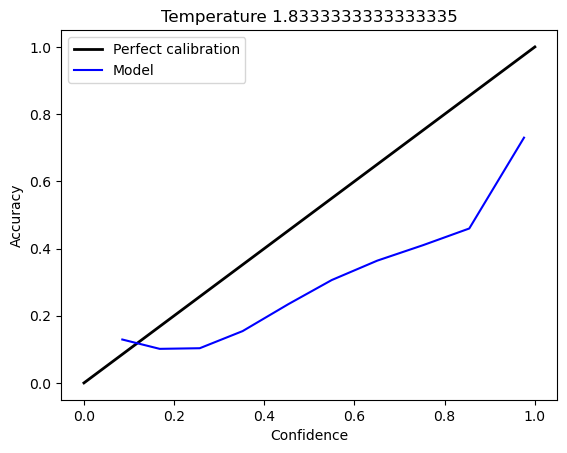

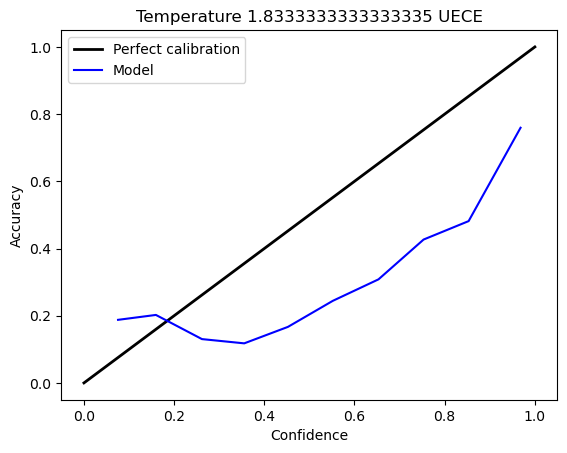

100%|██████████| 2000/2000 [04:58<00:00,  6.69it/s]


overall ece 0.22436835114323078
overall uece 0.21218113096593652


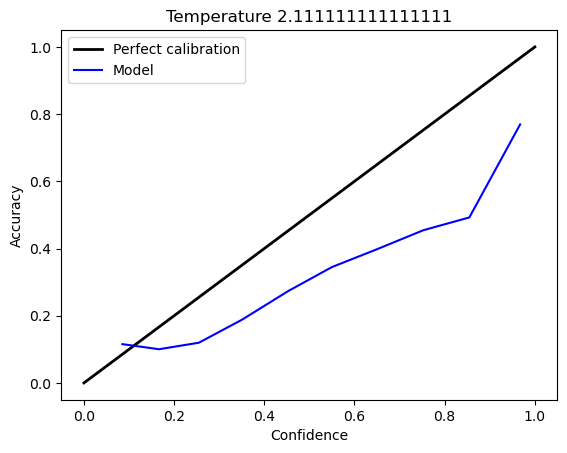

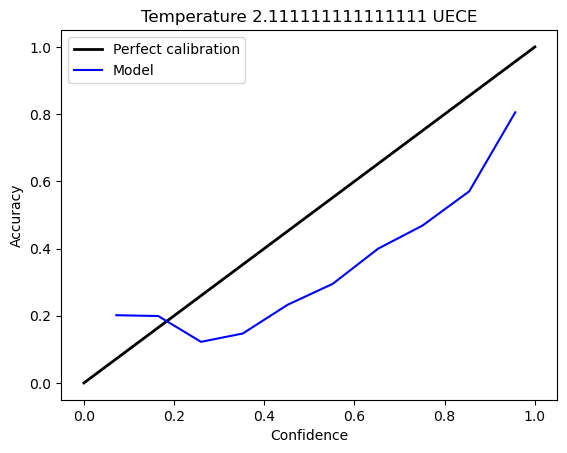

100%|██████████| 2000/2000 [06:12<00:00,  5.36it/s]


overall ece 0.17977756878778461
overall uece 0.15241718110584004


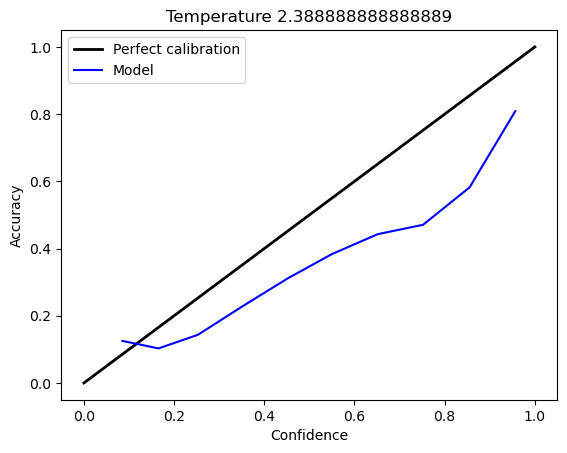

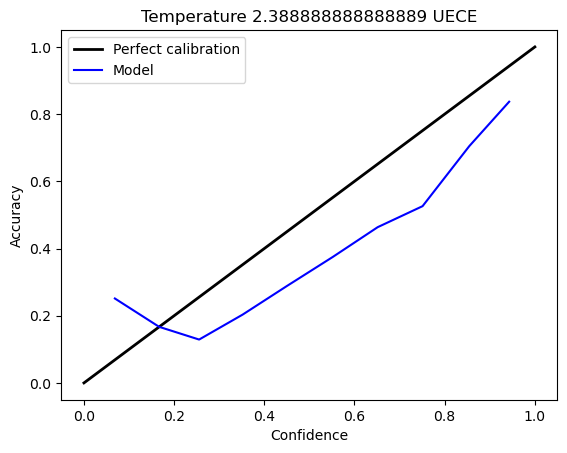

100%|██████████| 2000/2000 [07:57<00:00,  4.18it/s]

overall ece 0.13162760847305693
overall uece 0.08889989808657987


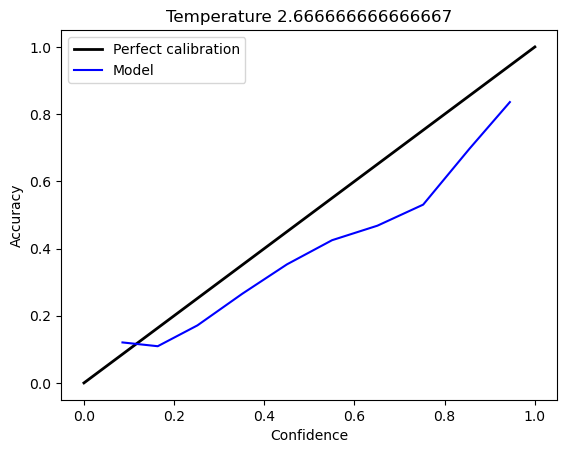

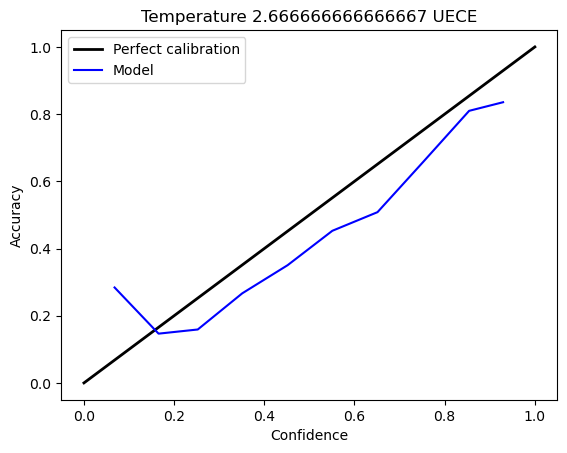

100%|██████████| 2000/2000 [10:27<00:00,  3.18it/s]


overall ece 0.08133195069100745
overall uece 0.029321414378019373


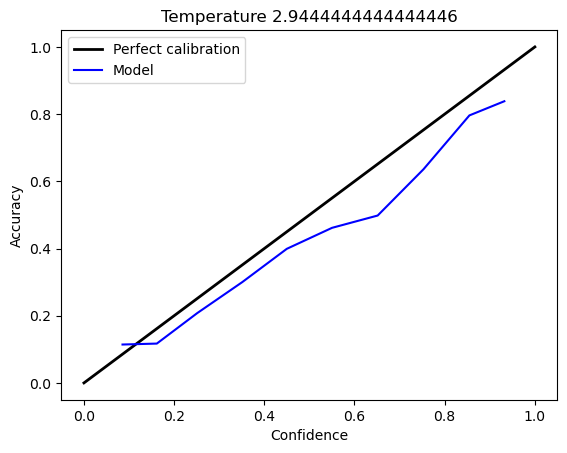

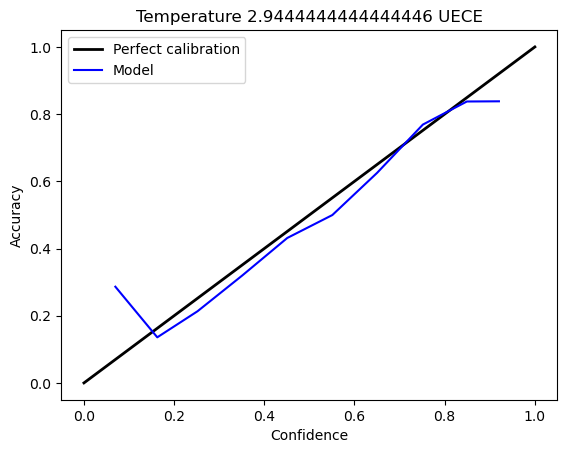

100%|██████████| 2000/2000 [08:32<00:00,  3.90it/s]

overall ece 0.03055113854459676
overall uece 0.04699228947305077


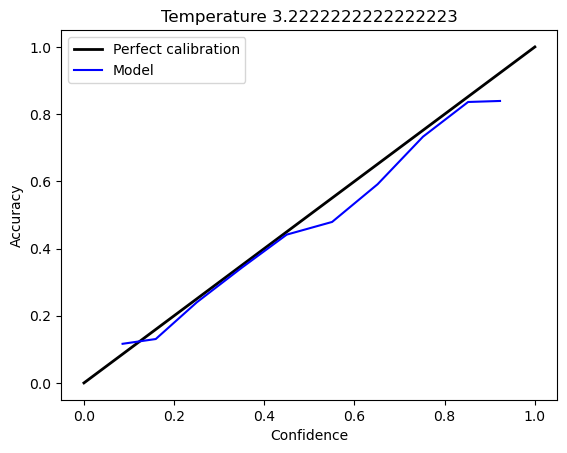

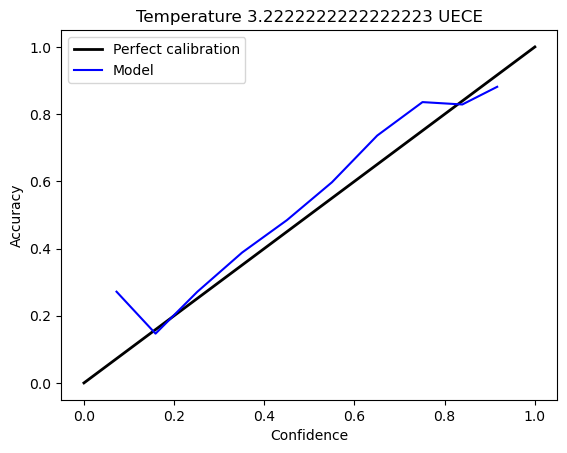

100%|██████████| 2000/2000 [08:54<00:00,  3.74it/s]

overall ece 0.028198832327479904
overall uece 0.10383650524402062


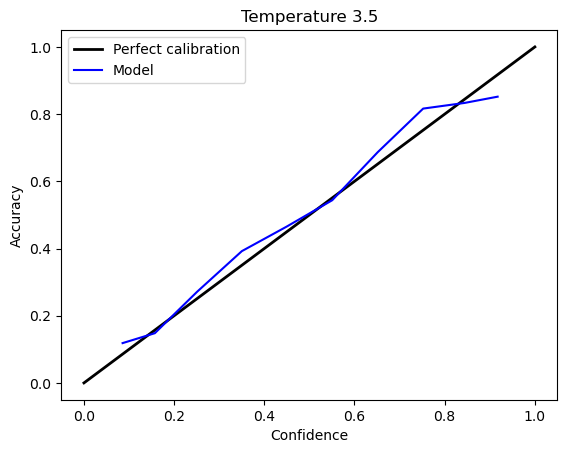

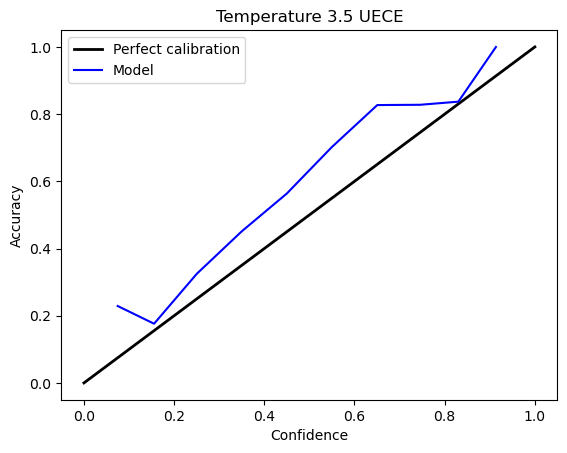

In [23]:
# GRID SEARCH ON TEMPERATURE

for t in np.linspace(1, 3.5, 10):
    bin_confidences_avg, bin_accuracies_avg, overall_ece, ubin_confidences_avg, ubin_accuracies_avg, overal_uece  = compute(temp=t, split="train", num_items=2000)
    print("overall ece", overall_ece)
    print("overall uece", overal_uece)
    plot(bin_confidences_avg, bin_accuracies_avg, title=f"Temperature {t}")
    plot(ubin_confidences_avg, ubin_accuracies_avg, title=f"Temperature {t} UECE")

In [ ]:
# GRID SEARCH ON TEMPERATURE

for t in np.linspace(2.6, 2.7, 10):
    bin_confidences_avg, bin_accuracies_avg, overall_ece, ubin_confidences_avg, ubin_accuracies_avg, overal_uece  = compute(temp=t, split="train", num_items=2000)
    print("overall ece", overall_ece)
    print("overall uece", overal_uece)
    plot(bin_confidences_avg, bin_accuracies_avg, title=f"Temperature {t}")
    plot(ubin_confidences_avg, ubin_accuracies_avg, title=f"Temperature {t} UECE")

In [ ]:
t=1
bin_confidences_avg, bin_accuracies_avg, overall_ece, ubin_confidences_avg, ubin_accuracies_avg, overal_uece  = compute(temp=t, split="val", num_items=2000)
print("overall ece", overall_ece)
print("overall uece", overal_uece)
plot(bin_confidences_avg, bin_accuracies_avg, title=f"Temperature {t}")
plot(ubin_confidences_avg, ubin_accuracies_avg, title=f"Temperature {t} UECE")

In [ ]:
t=2.63
bin_confidences_avg, bin_accuracies_avg, overall_ece, ubin_confidences_avg, ubin_accuracies_avg, overal_uece  = compute(temp=2.5, split="val")
print("overall ece", overall_ece)
print("overall uece", overal_uece)
plot(bin_confidences_avg, bin_accuracies_avg, title=f"Temperature {t}")
plot(ubin_confidences_avg, ubin_accuracies_avg, title=f"Temperature {t} UECE")

In [ ]:
t=2.63
bin_confidences_avg, bin_accuracies_avg, overall_ece, ubin_confidences_avg, ubin_accuracies_avg, overal_uece  = compute(temp=t, split="val")
print("overall ece", overall_ece)
print("overall uece", overal_uece)
plot(bin_confidences_avg, bin_accuracies_avg, title=f"Temperature {t}")
plot(ubin_confidences_avg, ubin_accuracies_avg, title=f"Temperature {t} UECE")

In [ ]:

def get_colormap(n):
    def bitget(byteval, idx):
        return (byteval & (1 << idx)) != 0

    cmap = np.zeros((n, 3), dtype="uint8")
    for i in range(n):
        r = g = b = 0
        c = i
        for j in range(8):
            r = r | (bitget(c, 0) << 7 - j)
            g = g | (bitget(c, 1) << 7 - j)
            b = b | (bitget(c, 2) << 7 - j)
            c = c >> 3
        cmap[i] = np.array([r, g, b])
    return cmap


In [ ]:
split = "val"
temp = 2.63
image_dir = (
f"/home/sai/Desktop/multi-object-search/EMSANet/datasets/hm3d_objnav_8_classes/{split}/rgb"
)
semantic_seg_gt = f"/home/sai/Desktop/multi-object-search/EMSANet/datasets/hm3d_objnav_8_classes/{split}/semantic_8"
rgb_images = sorted(glob.glob(image_dir + "/*.png"))
seg_gt_images = sorted(glob.glob(semantic_seg_gt + "/*.png"))
cmap = get_colormap(7)
for i in tqdm.tqdm(
    range(len(rgb_images))
):
    image = rgb_images[i]
    semantic_gt = seg_gt_images[i]
    # Get the semantic segmentation ground truth for the image
    semantic_gt_img = Image.open(semantic_gt)
    semantic_gt = torch.from_numpy(np.array(semantic_gt_img))
    semantic_gt -= 2
    semantic_gt[semantic_gt > 200] = 0
    if semantic_gt.max() == 0:
        continue
    image = Image.open(image)
    
    inputs = feature_extractor(image, return_tensors="pt").pixel_values.to(device)  

    with torch.no_grad():
        outputs = model(inputs)
    upsampled_logits = nn.functional.interpolate(
        outputs.logits,
        size=image.size[::-1],
        mode="bilinear",
        align_corners=False,
    ) / temp

    
    probs = torch.nn.functional.softmax(upsampled_logits[0], dim=0)
    
    normalized_entropy = -torch.sum(probs * torch.log(probs + 1e-6), dim=0) / np.log(probs.shape[0])
    conf = (1 - normalized_entropy)
    
    probs_seg = probs.max(dim=0).values

    pred_seg = upsampled_logits.argmax(dim=1)[0]     
    pred_seg_new = torch.zeros_like(pred_seg)
    
    for k, v in common2pred.items():
        for v1 in v:
            mask = pred_seg == v1
            pred_seg_new[mask] = k
    for k, v in common2pred.items():
        probs_seg[pred_seg_new == k] = probs[v].sum(dim=0)[pred_seg_new == k]
        
    # create an image with rgb, ground truth, prediction, create a heatmap of probs_seg and conf
    rgb_img = np.array(image)
    semantic_gt_img = cmap[semantic_gt.cpu().numpy()]
    pred_seg_new_img = cmap[pred_seg_new.cpu().numpy()]
    
    
    ucmap = plt.get_cmap("viridis")
    prob_seg_img = ucmap(probs_seg.cpu().numpy())
    prob_seg_img = np.delete(prob_seg_img.squeeze(), 3, 2) * 255
    
    conf_img = ucmap(conf.cpu().numpy())
    conf_img = np.delete(conf_img.squeeze(), 3, 2) * 255
    

    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    axs[0, 0].imshow(rgb_img)
    axs[0, 0].set_title("RGB")
    axs[0, 1].imshow(semantic_gt_img)
    axs[0, 1].set_title("Ground Truth")
    axs[0, 2].imshow(pred_seg_new_img)
    axs[0, 2].set_title("Prediction")
    axs[1, 0].imshow(prob_seg_img.astype(np.uint8))
    axs[1, 0].set_title("Heatmap of probs_seg")
    axs[1, 1].imshow(conf_img.astype(np.uint8))
    plt.show()
    
